# Model Summary

I built a linear regression model (for baseline) and logistic regression model using the heart disease dataset. After removing rows with outliers that were more than 3 standard deviations from the mean and dropping rows with data that had previously been dropped from the dataset, I had 290 cases. This was not a huge sample size, but it was fine for the purposes of exploratory data analysis and two relatively bare-bones models. 

Heat maps, histograms and bar charts revealed a number of relationships between various features and the target feature, heart disease. Unsurprisingly, incidences of chest pain (regular and exercise-induced) had some of the stronger correlations with heart disease, as did the presence of heart defects.

The __linear regression model__ did not do a very robust job at predicting heart disease, with a coefficient of determination __(R-squared) of .4633__. The model explained less than half of the variance in the data. Then again, performance is relative to the industry standards - it may be that, in the medical field, this R-squared value represents a strong linear regression model. 

The logistic regression model performed decently well, with precision, recall, accuracy and f-1 scores all at around __.79__. The original model yielded 11 false positives and 9 false negatives.

Looking forward, I hope to do more feature engineering around chest pain, slope and ST depression. These variables are still somewhat of a black box for me, and I think that, with more research, I could find helpful combinations or transformations that would yield features that make more sense.

I'd also like to take a look at a random forest model with these features, to practice my overall machine learning skills. I could also run Chi-square tests to accompany some of my charts in the EDA portion of this project, to see if certain values of features (for instance, being a man) are statistically more highly associated with having heart disease.


## Feature Normalizing

I will go through the data and normalize my continuous variables, unless they already fall between the range of 0 and 5 (roughly).

In [76]:
# Import our modules

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import zscore

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [77]:
# Read in the data from csv

heart_df = pd.read_csv("exported_heart_data.csv")

heart_df.head()

,age,sex,chest_pain,rest_bp,chol,blood_sugar,rest_ecg,max_hr,ex_angina,st_dep,slope,major_vessels,heart_defect,heart_disease
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [78]:
# Compute z-scores of age, rest_bp, chol, max_hr

norm_df = heart_df[["age", "rest_bp", "chol", "max_hr"]].apply(zscore)
norm_df.head()

,age,rest_bp,chol,max_hr
0,0.951005,0.765281,-0.257122,0.016013
1,-1.918374,-0.080924,0.114611,1.621804
2,-1.476931,-0.080924,-0.891255,0.970808
3,0.178480,-0.645061,-0.191522,1.231206
4,0.288841,-0.645061,2.388744,0.580210


In [79]:
# Combine these variables with the original categorical variables
# Do not include blood_sugar, which does not appear to correlate to heart disease (we can try the model with it later)

heart_df.drop(labels=["age", "rest_bp", "chol", "max_hr"], axis=1, inplace=True)
heart_df.head()

,sex,chest_pain,blood_sugar,rest_ecg,ex_angina,st_dep,slope,major_vessels,heart_defect,heart_disease
0,1,3,1,0,0,2.3,0,0,1,1
1,1,2,0,1,0,3.5,0,0,2,1
2,0,1,0,0,0,1.4,2,0,2,1
3,1,1,0,1,0,0.8,2,0,2,1
4,0,0,0,1,1,0.6,2,0,2,1


In [80]:
# Combine the two dataframes
# Oops, this one still includes blood_sugar

frames = [norm_df, heart_df]
heart_final_df = pd.concat(frames, axis = 1)
heart_final_df

,age,rest_bp,chol,max_hr,sex,chest_pain,blood_sugar,rest_ecg,ex_angina,st_dep,slope,major_vessels,heart_defect,heart_disease
0,0.951005,0.765281,-0.257122,0.016013,1,3,1,0,0,2.3,0,0,1,1
1,-1.918374,-0.080924,0.114611,1.621804,1,2,0,1,0,3.5,0,0,2,1
2,-1.476931,-0.080924,-0.891255,0.970808,0,1,0,0,0,1.4,2,0,2,1
3,0.178480,-0.645061,-0.191522,1.231206,1,1,0,1,0,0.8,2,0,2,1
4,0.288841,-0.645061,2.388744,0.580210,0,0,0,1,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,0.288841,0.483212,-0.082188,-1.155780,0,0,0,1,1,0.2,1,0,3,0
286,-1.035488,-1.209198,0.420745,-0.765183,1,3,0,1,0,1.2,1,0,3,0
287,1.502809,0.708867,-1.131788,-0.374585,1,0,1,1,0,3.4,1,2,3,0
288,0.288841,-0.080924,-2.487521,-1.502978,1,0,0,1,1,1.2,1,1,3,0


## Linear Regression Model

In [81]:
# Set our X and y

X = heart_final_df.drop(['heart_disease'], axis=1)
y = heart_final_df['heart_disease']

# Split features and labels into train and test data (this step also randomizes the data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

# Define the model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Get model predictions from the test data
y_predicted = model.predict(X_test)

# Compare y_test to predictions to get performance metrics
print(metrics.r2_score(y_test, y_predicted))

0.4632766537263635


We discussed looking at the actual predicted scores from this model to see what they represent! My thought is that they would fall between 0 and 1, but that may not always be the case. Kelley pointed out that I could also engineer the results to a 0 - 1 range.

Feature: 0, Score: 0.01084
Feature: 1, Score: -0.03445
Feature: 2, Score: -0.04583
Feature: 3, Score: 0.06504
Feature: 4, Score: -0.21537
Feature: 5, Score: 0.14618
Feature: 6, Score: 0.00870
Feature: 7, Score: -0.00034
Feature: 8, Score: -0.09507
Feature: 9, Score: -0.06713
Feature: 10, Score: 0.07500
Feature: 11, Score: -0.12094
Feature: 12, Score: -0.09949


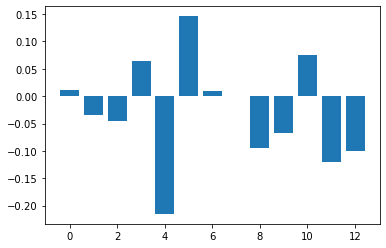

In [82]:
# Check the importance of different features in the linear regression model

importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

It appears that __age__, __blood_sugar__ and __rest_ecg__ are not of great importance in this model. __Chest_pain__ is majorly important.

## Logistic Regression Model

In [83]:
# We can use the same X and y split from before
# Fit a logistic regression model

model = LogisticRegression()
model.fit(X_train, y_train)

# Obtain model predictions
predicted = model.predict(X_test)

# Print the classification report and confusion matrix

print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classification report:
               precision    recall  f1-score   support

           0       0.80      0.77      0.79        48
           1       0.78      0.81      0.80        48

    accuracy                           0.79        96
   macro avg       0.79      0.79      0.79        96
weighted avg       0.79      0.79      0.79        96

Confusion matrix:
 [[37 11]
 [ 9 39]]


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.909


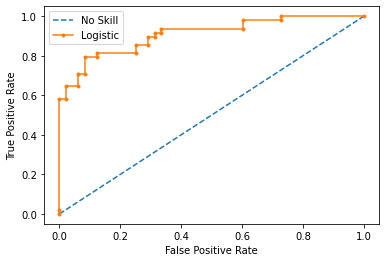

In [75]:
# Plot the ROC curve for this model

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

This ROC curve for our model does well at depicting the trade-off between identifying true positives and false positives (over-labeling our positives in an effort to capture more, basically). We see that, at a true positive rate of around .8, we hit a sort of plateau in identifying more true positives, at the cost of identifying more false positives. It would be interesting to see this curve plotted for a larger dataset, as it would hypothetically be smoother if there were more data points.

Feature: 0, Score: 0.02520
Feature: 1, Score: -0.34355
Feature: 2, Score: -0.49607
Feature: 3, Score: 0.49066
Feature: 4, Score: -1.53004
Feature: 5, Score: 1.01132
Feature: 6, Score: 0.20870
Feature: 7, Score: 0.05156
Feature: 8, Score: -0.51650
Feature: 9, Score: -0.56376
Feature: 10, Score: 0.59986
Feature: 11, Score: -0.97758
Feature: 12, Score: -0.67593


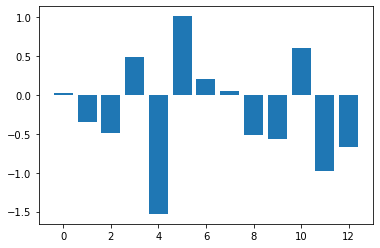

In [84]:
# Check the importance of different features in the logistic regression model

importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

As before, it appears that __age__, __blood_sugar__ and __rest_ecg__ are not of great importance in this model.

## Re-Examine Rest Ecg, Remove Blood Sugar and Age

Based on what we know about rest_ecg, it might make more sense to transform it into a binary variable. The original values are 0 - 2: 0 = probable left ventricular hypertrophy, 1 = normal, and 2 = abnormalities in the T wave or ST segment. 

We can group 0 and 2 into the "abnormal" category (0) and 1 into the normal category (still 1).

In [70]:
# Replace 2 with 0 in the rest_ecg column
heart_final_df["rest_ecg"].replace({2: 0}, inplace=True)
heart_final_df.head()

# Drop the age and blood_sugar columns
#drop_age_df = heart_final_df.drop(labels=["age", "blood_sugar"], axis=1, inplace=True)


,age,rest_bp,chol,max_hr,sex,chest_pain,blood_sugar,rest_ecg,ex_angina,st_dep,slope,major_vessels,heart_defect,heart_disease
0,0.951005,0.765281,-0.257122,0.016013,1,3,1,0,0,2.3,0,0,1,1
1,-1.918374,-0.080924,0.114611,1.621804,1,2,0,1,0,3.5,0,0,2,1
2,-1.476931,-0.080924,-0.891255,0.970808,0,1,0,0,0,1.4,2,0,2,1
3,0.178480,-0.645061,-0.191522,1.231206,1,1,0,1,0,0.8,2,0,2,1
4,0.288841,-0.645061,2.388744,0.580210,0,0,0,1,1,0.6,2,0,2,1


## Model with New Rest ECG Value

In [71]:
# Reset the X and y values with our new data

X = heart_final_df.drop(['heart_disease'], axis=1)
y = heart_final_df['heart_disease']

# Split features and labels into train and test data (this step also randomizes the data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

# Fit a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Obtain model predictions
predicted = model.predict(X_test)

# Print the classification report and confusion matrix

print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classification report:
               precision    recall  f1-score   support

           0       0.81      0.79      0.80        48
           1       0.80      0.81      0.80        48

    accuracy                           0.80        96
   macro avg       0.80      0.80      0.80        96
weighted avg       0.80      0.80      0.80        96

Confusion matrix:
 [[38 10]
 [ 9 39]]


Based on this confusion matrix, there were __10 false positives__ and __9 false negatives__. Our __overall accuracy is 80%__, which isn't too shabby.

Transforming rest_ecg improved our scores a tiny amount, but dropping age and blood sugar decreased them. It's worth trying some more feature engineering with other categorical variables (that are not orginal or binary) and keeping features in, rather than eliminating them.

## Transform Categorical Variables

First, take a look at __chest pain__ (the most important feature, based on coefficients). Current values are 0 for no chest pain or 1-4 for different types of chest pain. 1 = typical angina, 2 = atypical angina, 3 = non-anginal pain and 4 = asymptomatic. Asymptomatic is a bit confusing because it seems like that would not involve pain. I'm going to sort this into pain (1, 2 and 3 = 1) and no pain (0 and 4).


In [72]:
heart_final_df["chest_pain"].replace({2:1, 3:1, 4:0}, inplace=True)
heart_final_df.head()

,age,rest_bp,chol,max_hr,sex,chest_pain,blood_sugar,rest_ecg,ex_angina,st_dep,slope,major_vessels,heart_defect,heart_disease
0,0.951005,0.765281,-0.257122,0.016013,1,1,1,0,0,2.3,0,0,1,1
1,-1.918374,-0.080924,0.114611,1.621804,1,1,0,1,0,3.5,0,0,2,1
2,-1.476931,-0.080924,-0.891255,0.970808,0,1,0,0,0,1.4,2,0,2,1
3,0.178480,-0.645061,-0.191522,1.231206,1,1,0,1,0,0.8,2,0,2,1
4,0.288841,-0.645061,2.388744,0.580210,0,0,0,1,1,0.6,2,0,2,1


In [73]:
# I realize I could write a function to try out different dataframes here... come back and do that!

X = heart_final_df.drop(['heart_disease'], axis=1)
y = heart_final_df['heart_disease']

# Split features and labels into train and test data (this step also randomizes the data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

# Fit a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Obtain model predictions
predicted = model.predict(X_test)

# Print the classification report and confusion matrix

print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classification report:
               precision    recall  f1-score   support

           0       0.80      0.75      0.77        48
           1       0.76      0.81      0.79        48

    accuracy                           0.78        96
   macro avg       0.78      0.78      0.78        96
weighted avg       0.78      0.78      0.78        96

Confusion matrix:
 [[36 12]
 [ 9 39]]


Interestingly, this made the model slightly worse in overall accuracy, and increased our false positives by 2 (not fun for those people). I'm going to stop fiddling around with things for now, call it a day and work on my write-up!